In [1]:
#Library Calls
using Gen
using LinearAlgebra
using Distributions
using Random
using PyPlot
using Flux;

In [3]:
#I'll make my own damn HMC sampler, with blackjack and hookers
#Page 14 of the Neal HMC Chapter (HB of MCMC)
function jon_hmc(trace, grad_U, ϵ, L, current_q, observations=EmptyChoiceMap())
    U = get_score(trace)
    q = current_q
    p = rand(Normal(0,1),length(q))
    current_p = p
    
    #Make a half-step for momentum at the beginning
    p = p - ϵ * grad_U(q) / 2
    
    #Alternate full steps for position and momentum
    for i=1:L
       #Make a full step for the position
        q = q + ϵ * p
        #Make a full step for the momentum, except at end of trajectory
        p = i!=L ? p - ϵ * grad_U(q) : p
    end
    
    #Make a half-step for momentum at the end
    p = p - ϵ * grad_U(q) / 2
    
    #Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    
    #Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = sum(current_p^2)
    proposed_U = U(q)
    proposed_K = sum(p^2) / 2
    
    #Accept or reject the state at the end of the trajectory. Return either
    #the position at the end, or the initial position
    if rand(Uniform(0,1),1) < exp(current_U - proposed_U + current_K - proposed_K) #EQ 3.16 PG 12
        return(q) #ACCEPT
    else
        return(current_q) #REJECT
    end
end

jon_hmc (generic function with 2 methods)

In [4]:
#There's very little meat in these auxiliary momentum variables
#U(q) = -log[π(q)L(q|D)] - Negative 
function U(trace)
    return(get_score(trace)/length(get_retval(trace)))
end;

U (generic function with 1 method)

In [5]:
#See all those gradients, Homer? Thats why your HMC sampler didn't work!
function grad_U()
    return("There's nothing here") 
end;

grad_U (generic function with 1 method)

In [8]:
#Look at those hyperparameters fly
n = 500
N = 1200
σₐ = 0.002
k_range = 12
k_list = [i for i in 1:k_range];

In [9]:
#I am helping to make your boots go faster
function plot_data(data,classes)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],marker=markers[i],zorder=3)
    end
end;

function unpack(Θ,k)
    m = length(Θ)
    h = 2*k
    Wₕ = reshape(Θ[1:h], k, 2);   
    bₕ = reshape(Θ[h+1:h+k], k)
    bₕ = bₕ
    
    Wₒ = reshape(Θ[h+k+1:m-1], 1, k);
    bₒ = Θ[m]
      
    return Wₕ, bₕ, Wₒ, bₒ
end

function data_labeller(y::Array{Float64})
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

function sigmoid(x::Array{Float64}, a=10000)
    return 1.0 ./ (1.0 .+ a.*exp.(-x))
end

function hardσ(x, a=2)
    max(0, min(1.0, a * x + 0.5))
end
    
#function sigmoid(x::Float64, a=1)
    #return 1.0 / 1.0 + a*exp(-x)
#end

mₖ(k) = k*4 + 1

#Test out the unpack method
k = 5
m = mₖ(k)
θtest = [i for i=1:m]
a,b,c,d = unpack(θtest,k)

([1 6; 2 7; … ; 4 9; 5 10], [11, 12, 13, 14, 15], [16 17 … 19 20], 21)

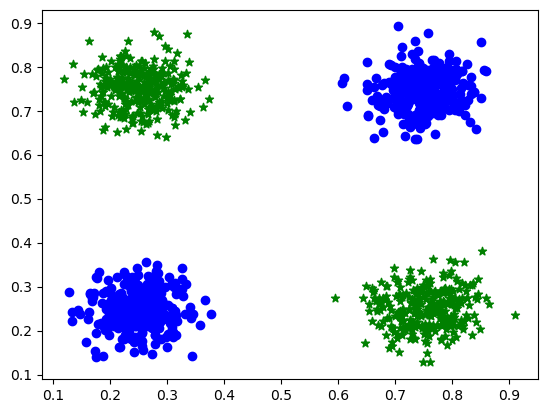

In [10]:
#Simulated Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [0.25, 0.25]
    μ₂ = [0.25, 0.75]
    μ₃ = [0.75, 0.75]
    μ₄ = [0.75, 0.25]
    #μ₅ = [1.25, 1.25]
    #μ₆ = [1.25, 1.75]
    #μ₇ = [1.75, 1.75]
    #μ₈ = [1.75, 1.25]
    μ = [μ₁, μ₂, μ₃, μ₄]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/4), 4, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]

plot_data(data_raw,classes)
data = transpose(data_raw)
size(data);

In [42]:
#Bayesian Neural Net
function G(x, Θ::AbstractVector, k::Int)
    if(typeof(x) == Float64)
        x = [x]
    end
    W₁, b₁, W₂, b₂ = unpack(Θ,k)
    nn = Chain(Dense(W₁, b₁, tanh),
               Dense(W₂, [b₂], hardσ))
    ps = Flux.params(nn)
    return nn(x), ps
end;

@dist k_count(r,p,min) = neg_binom(r,p) + 1

@gen function classifier(x::Array{Float64})
    σₖ = 100.0::Float64
    
    # Create the weight and bias vector.
    #k ~ uniform_discrete(1,k_range)
    #k ~ k_count(1,0.5,1)
    k=2
    m = mₖ(k)
    μ = zeros(m)
    Σ = Diagonal([σₖ for i=1:m])
    Θ ~ mvnormal(μ,Σ) #Coefficients of the polynomial
    
    #Return Network Scores for X
    #W₁, b₁, W₂, b₂ = unpack(Θ,k)
    h = 2*k
    
    nn = Chain(Dense(reshape(Θ[1:h], k, 2), reshape(Θ[h+1:h+k], k), tanh),
               Dense(reshape(Θ[h+k+1:m-1], 1, k), [Θ[m]], hardσ))
    
    ps = Flux.params(nn)
    scores = nn(x)
    #scores, _ = G(x,Θ,k)
    #scores = sigmoid(nn_out,10000)
    
    #Logistic Regression Likelihood
    y = zeros(length(x[1,:])) #Array to fill with class labels
    for j=1:N
        y[j] = @trace(categorical([1-scores[j],scores[j]]), (:y,j))
    end
    return y
end;

z = classifier(data)

#k = 4
#m = mₖ(k)
#θ = ones(m)
#out, ps = G(data, θ, k)
#gs = Flux.gradient(() -> sum(G(data,θ,k)), ps)
#Flux.gradient(G, out, ps, k)[2]

1200-element Array{Float64,1}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 ⋮
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

In [32]:
#Register Observed Data
obs = choicemap()::ChoiceMap
for j in 1:length(classes)
    obs[(:y, j)] = classes[j]
end;

(trace,) = generate(classifier, (data,), obs)

(Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Array{Float64,N} where N], false, Union{Nothing, Some{Any}}[nothing], ##classifier#385, Bool[0], false), Trie{Any,Gen.ChoiceOrCallRecord}(Dict{Any,Gen.ChoiceOrCallRecord}((:y, 909) => Gen.ChoiceOrCallRecord{Int64}(2, -Inf, NaN, true),(:y, 875) => Gen.ChoiceOrCallRecord{Int64}(1, 0.0, NaN, true),(:y, 1048) => Gen.ChoiceOrCallRecord{Int64}(2, -Inf, NaN, true),(:y, 969) => Gen.ChoiceOrCallRecord{Int64}(2, -Inf, NaN, true),(:y, 684) => Gen.ChoiceOrCallRecord{Int64}(1, 0.0, NaN, true),(:y, 224) => Gen.ChoiceOrCallRecord{Int64}(1, 0.0, NaN, true),(:y, 389) => Gen.ChoiceOrCallRecord{Int64}(2, -Inf, NaN, true),(:y, 718) => Gen.ChoiceOrCallRecord{Int64}(1, 0.0, NaN, true),(:y, 606) => Gen.ChoiceOrCallRecord{Int64}(1, 0.0, NaN, true),(:y, 557) => Gen.ChoiceOrCallRecord{Int64}(2, -Inf, NaN, true)…), Dict{Any,Trie{Any,Gen.ChoiceOrCallRecord}}()), false, -Inf, 0.0, ([0.3020086345392577

In [78]:
get_gen_fn(trace)

##classifier#385 (generic function with 1 method)

In [91]:
@gen function line_model(xs::Vector{Float64})
    n = length(xs)
    slope = @trace(normal(0,1), :slope)
    intercept = @trace(normal(0,2), :intercept)
    
    for i = 1:length(xs)
        #println(slope * xs[i] + intercept)
        @trace(normal(slope*xs[i] + intercept, 0.1),(:y,i))
    end
    
    return n
end;
xs = [-5.,-4.,-3.,-2.,-1.,0.,1.,2.,3.,4.,5.]

n = line_model(xs)
println(n)

11


In [116]:
trace = simulate(line_model, (xs,))
get_gen_fn(trace).params

Dict{Symbol,Any} with 0 entries